# MONOCAMCCDRed a package to do CCD reduction for MONOCAM/LSST
===============================================================================================================

This is the notebook to do the whole CCD reduction pipeline using the **CCDPROC** python package from astropy astronomical tools.
We are considering raw data images that comes from fits file which header does not full conform to standard.
Some keywords are missing.

This notebook target bias and darks calculations.

- Creation date : Friday 2016 June 3rd
- Update : Monday 2016 June 6th
- Author Sylvie Dagoret-Campagne (SDC adapted for LSST from Matt Craig's example notebook)
- affiliation : LAL/IN2P3/CNRS

This notebook is inspired and adapted from the Matt Craig notebook available here
http://nbviewer.jupyter.org/gist/mwcraig/06060d789cc298bbb08e

## 1.) Required softwares

Please make sure you have this software installed before you begin (in addition to the usual scipy, numpy):

+ [astropy](http://astropy.org) v 0.4 or higher (install with: ``pip install astropy`` in a terminal/command window)
+ [ccdproc](http://ccdproc.readthedocs.org) v 0.1.1 or higher (install with: ``pip install ccdproc`` in a terminal/command window)
+ [msumastro](http://msumastro.readthedocs.org) v 0.5 or higher (install with : ``pip install msumastro`` in a terminal/command window)

## 2.) Main Packages imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits

import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [2]:
from scipy import stats  
import os
from datetime import datetime, timedelta

In [3]:
import libMonocamBaseImages as monoc

In [4]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.0.0


In [5]:
from msumastro import ImageFileCollection, TableTree
# I know you can't do correlated errors....
nddata.conf.warn_unsupported_correlated = False

In [6]:
now=datetime.utcnow()  # choose UTC time
datestr=str(now)
print 'standard date format for the analysis :',datestr
#  want the following format '2016-05-10T11:55:27.267'
date_of_analysis=now.strftime('%Y-%m-%dT%H:%M:%S')
print 'fits date format for the analysis : ',date_of_analysis

standard date format for the analysis : 2016-06-07 05:11:09.952583
fits date format for the analysis :  2016-06-07T05:11:09


## 3) Set some properties of the instrument that took these images

- MONOCAM, one of the 200 CCD plate of LSST camera.
- This CCD is 4Kx4K readout by 16 amplifiers

Eeach fits file contains a primary header plus the 16 images

- 16 images of size 544 x 2048 pixels
corresponding of :
- 8 columns of 544 pixels : 8 x 544 = 4352 pixels 
- 2 raws of 2048 pixels : 2 x 2048 = 4096 pixels

There is an excess of 4352-4096= 256 pixels along the columns.
It is possible there is 32 overscan slots.


A pre-look to the flats data using ds9 or python script allowed me to guess what are the Trim section and the Bias section

In [7]:
NB_OF_CHAN_AMPL=16    # 16 images in each of the fits file

# 4. Define a few convenience functions

All of these are really optional, but some are pretty convenient. They are provided in part to illustrate how one can combine the basic ``ccdproc`` commands into something more like a pipeline.

## a. Subtract overscan and trim images in a list

I have checked that substracting overscan region reduce very significantly the width of the pedestals (biases) distribution.
Obviously it is necessary to apply this pre-correction image by image.

(SDC)

In [8]:
def oscan_and_trim(image_list):
    """
    Remove overscan and trim a list of images. The original list is replaced by a list of images
    with the changes applied.
    """
    for idx, img in enumerate(image_list):
        oscan = ccdproc.subtract_overscan(img,overscan=img[:,521:544], add_keyword={'oscan_sub': True, 'calstat': 'O'}, model=models.Polynomial1D(1))
        image_list[idx] = ccdproc.trim_image(oscan[:,10:521], add_keyword={'trimmed': True, 'calstat': 'OT'})

## b. Calculate fast medians (only really needed until numpy 1.9)

###     A bottleneck-based replacement for ma.median for a *single* array

As explained above, in numpy 1.8.1 and lower the masked median of a stack of images is very slow.

In [9]:
def bn_median(masked_array, axis=None):
    """
    Perform fast median on masked array
    
    Parameters
    ----------
    
    masked_array : `numpy.ma.masked_array`
        Array of which to find the median.
    
    axis : int, optional
        Axis along which to perform the median. Default is to find the median of
        the flattened array.
    """
    data = masked_array.filled(fill_value=np.NaN)
    med = bn.nanmedian(data, axis=axis)
    # construct a masked array result, setting the mask from any NaN entries
    return np.ma.array(med, mask=np.isnan(med))

### A bottleneck-based replacement for a stack (i.e. list) of masked arrays

By "stack" I mean a group of images, e.g. darks of the same exposure, for which the appropriate baseline image for identifying bad pixels is a median image (rather than a median or mean of the whole stack)

In [10]:
def avg_over_images(masked_arr, axis=0):
    """
    Calculate average pixel value along specified axis
    """
    return ma.mean(masked_arr, axis=axis)

def med_over_images(masked_arr, axis=0):
    """
    Calculate median pixel value along specified axis
    
    Uses bottleneck.nanmedian for speed
    """
    
    dat = masked_arr.data.copy()
    dat[masked_arr.mask] = np.NaN
    return bn.nanmedian(dat, axis=axis)

### A little function for displaying image statistics....

..which is useful for determining scale when displaying an image.

In [11]:
imstats = lambda dat: (dat.min(), dat.max(), dat.mean(), dat.std())

### To make the list of biases

In [12]:
def BuildFilelist(path,name,ext='.fits',start=1,stop=99):
    '''
    Make the list of filenames required by ccdproc
    
    input:
       path : path of files
       name : common root of bias filenames
       ext  : extension of filenames
       start,stop : indexes of files
    output:
       full filename list
    '''
    filelist = []
    for num in range(start,stop+1,1):
        strnum=biasnumberstr= '{0:02d}'.format(num)  # python >= 2.6
        filename=name+strnum+ext
        fullfilename=os.path.join(path,filename)
        filelist.append(fullfilename)
    return filelist

## 5.) Read data

In [13]:
path='/Users/dagoret-campagnesylvie/iraf/MonoCamMay2016/20160509'
ext_filename='.fits'

## 6 ) The biases
=====================

In [14]:
root_biasfilename='bias_'
bias_startnum=1
bias_stopnum=50

In [15]:
rawbias_list=BuildFilelist(path,root_biasfilename,start=bias_startnum,stop=bias_stopnum)

In [16]:
NB_OF_BIAS=len(rawbias_list)

In [17]:
masterbias_out_filename='masterbias_ostrim_1.fits'

### a. First, load the data as a list of ``CCDData`` objects.

If you don't need to modify the metadata you could use ``ccdproc.CCDData.from_hdu(hdu)`` to create the ``CCDData`` object.

In [18]:
allrawbias = []
for chan in range(1,NB_OF_CHAN_AMPL+1,1):
    ccd_chan = [ ccdproc.CCDData.read(image_file, hdu=chan,unit="adu") for image_file in rawbias_list ]
    allrawbias.append(ccd_chan)

In [19]:
type(allrawbias[0][0])

ccdproc.ccddata.CCDData

In [20]:
mbheader=allrawbias[0][0].header
mbheader['DATE-ANA']=date_of_analysis

### b. Subtract overscan and trim using convenience function

In [21]:
for chan in range(NB_OF_CHAN_AMPL):
    oscan_and_trim(allrawbias[chan])

### c. Combine biases using average

In [22]:
masterbias_list=[]
for chan in range(NB_OF_CHAN_AMPL):
    biases = ccdproc.Combiner(allrawbias[chan])
    #master_bias = biases.average_combine() # assymetric pedestals ==>  Not good at all, but perhaps we prefer this ?
    master_bias = biases.median_combine()  # median gives much more symetric gaussian distributed pedestals
    masterbias_list.append(master_bias)

### d. Make a pretty picture...

Because why wouldn't you?

In [23]:
print 'channel bias_min, bias_max, bias_mean, bias_std'
for chan in range(NB_OF_CHAN_AMPL):
    bias_min, bias_max, bias_mean, bias_std = imstats(np.asarray(masterbias_list[chan]))
    print chan+1,bias_min, bias_max, bias_mean, bias_std
    
    #plt.figure(figsize=(5, 5))
    #plt.imshow(masterbias_list[chan], vmax=bias_mean + 4*bias_std, vmin=bias_mean - 4*bias_std)

channel bias_min, bias_max, bias_mean, bias_std
1 -0.952487032942 2.22890796464 0.52412098655 0.405690252309
2 -1.16875017384 3.21116672131 0.835123553886 0.436710278374
3 -1.35943785773 2.29913690471 0.582151819577 0.351282220076
4 -1.24801607268 2.13536082393 0.440461607753 0.396602242374
5 -1.61020449616 2.17614686044 0.417946907554 0.391433684322
6 -1.33269092516 2.17256144019 0.367089552783 0.403332187422
7 -1.21058082508 2.19168533557 0.53106740456 0.41577432511
8 -1.22059267322 50.8024038395 0.510564206495 0.393219514833
9 -1.44845854848 2.81475592924 0.570777070836 0.459631714664
10 -1.53580903815 2.43070151847 0.318736565129 0.452002107085
11 -1.60428125253 2.62629346877 0.413533285763 0.439983250228
12 -1.37842289011 3.1952920956 0.594821859163 0.485783669881
13 -1.73322875247 75.2487472038 0.336126402241 0.460764436441
14 -1.44021325225 75.0087383352 0.726649707 0.452902587068
15 -3.05358885328 32.1086303781 0.64348879772 0.798061738472
16 -1.45196405145 161.102574031 0.5510

In [24]:
def ShowMBImagesSet(masterbiaslist):
    '''
    Shows the whole set of CCD images
     - inputs argument:
       path : path of the fits file
       filename of the fits file
     - output the images of the whole CCD   
    '''
     
    NX=8 # number of images along the horizontal axis
    NY=2 # number of images along the vertical axis
    BIASMIN=-2.0
    BIASMAX=2.0
    f, axarr = plt.subplots(NY,NX,sharex='col', sharey='row',figsize=(15,15)) # figure organisation
    
    f.subplots_adjust(hspace=0.125,wspace=0.1)

    for index in range(NB_OF_CHAN_AMPL):  
        ix=index%8
        iy=index/8
        image_data = masterbiaslist[index].data
        im=axarr[iy,ix].imshow(image_data,vmin=BIASMIN,vmax=BIASMAX)  # plot the image
        if ix==0 and iy==0:
            im0=im
        plottitle='channel {}'.format(index+1)
        axarr[iy,ix].set_title(plottitle)
    
    title='Master Biases'
    cax = f.add_axes([0.95, 0.12, 0.03, 0.78]) # [left,bottom,width,height]    
    f.colorbar(im0, cax=cax)
   
    plt.suptitle(title,size=16)
    plt.savefig('masterbias_ostrim.pdf', bbox_inches='tight')

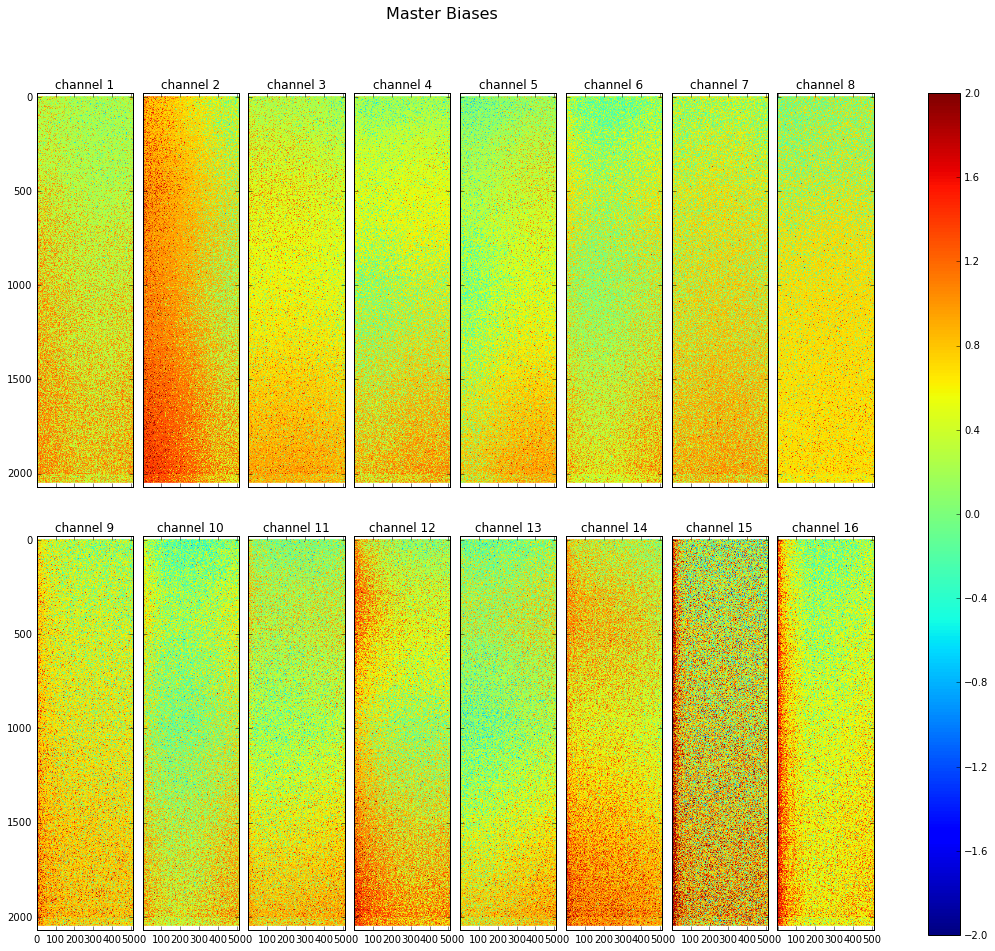

In [25]:
ShowMBImagesSet(masterbias_list)

In [26]:
def ShowMBHistoSet(masterbiaslist):
    '''
    Shows the whole set of CCD histograms
     - inputs argument:
       path : path of the fits file
       filename of the fits file
     - output the images of the whole CCD   
    '''
   
    
    NX=4 # number of images along the horizontal axis
    NY=4 # number of images along the vertical axis
    BIASMIN=-10.0
    BIASMAX=10.0
    BINWIDTH=0.25
    f, axarr = plt.subplots(NY,NX,figsize=(20,20)) # figure organisation
    #f, axarr = plt.subplots(NX,NY,sharex=True, sharey=True,figsize=(20,20))
    f.subplots_adjust(hspace=0.5,wspace=0.5)

    for index in range(NB_OF_CHAN_AMPL):  
        ix=index%4
        iy=index/4
        image_data = image_data = masterbiaslist[index].data
        data=image_data.flatten()
        axarr[iy,ix].hist(data,bins=np.arange(min(data), max(data) + BINWIDTH, BINWIDTH),facecolor='blue', alpha=0.75,log=True)  # plot the image
        #axarr[iy,ix].hist(data,bins=np.arange(min(data), max(data) + BINWIDTH, BINWIDTH),facecolor='blue', alpha=0.70,log=False)  # plot the image
        plottitle='channel {}'.format(index+1)
        axarr[iy,ix].set_xlim(BIASMIN,BIASMAX)
        axarr[iy,ix].set_title(plottitle)
        axarr[iy,ix].set_xlabel('ADU')
        axarr[iy,ix].grid(True)
        #axarr[iy,ix].set_yscale('log')

    plt.yscale('log')
    title='Master Bias for combined biases with median substraction'
    plt.suptitle(title,size=16)
    plt.savefig('masterbias_ostrim_histos.pdf', bbox_inches='tight')

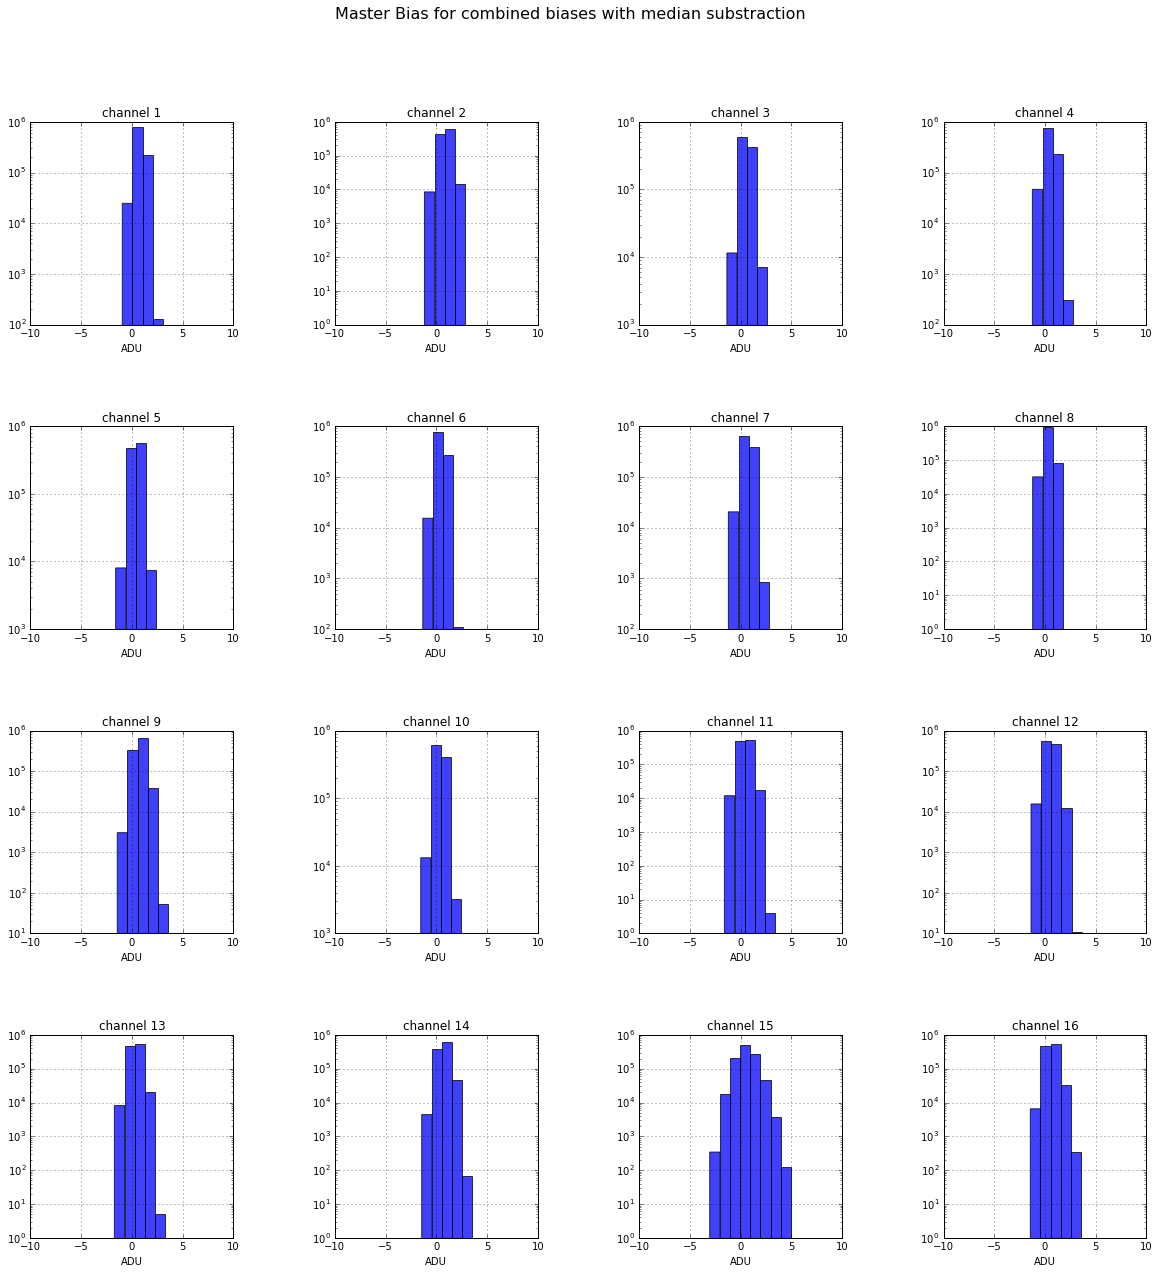

In [54]:
ShowMBHistoSet(masterbias_list)

### e) Save the masterbias file

In [28]:
monoc.SaveCCDListIntoFitsFile(masterbias_list,masterbias_out_filename,mbheader,imagetyp='master_bias')

header to be written in file ::
-------------------------------
1
OrderedDict([(u'NCOMBINE', 50)])
2
OrderedDict([(u'NCOMBINE', 50)])
3
OrderedDict([(u'NCOMBINE', 50)])
4
OrderedDict([(u'NCOMBINE', 50)])
5
OrderedDict([(u'NCOMBINE', 50)])
6
OrderedDict([(u'NCOMBINE', 50)])
7
OrderedDict([(u'NCOMBINE', 50)])
8
OrderedDict([(u'NCOMBINE', 50)])
9
OrderedDict([(u'NCOMBINE', 50)])
10
OrderedDict([(u'NCOMBINE', 50)])
11
OrderedDict([(u'NCOMBINE', 50)])
12
OrderedDict([(u'NCOMBINE', 50)])
13
OrderedDict([(u'NCOMBINE', 50)])
14
OrderedDict([(u'NCOMBINE', 50)])
15
OrderedDict([(u'NCOMBINE', 50)])
16
OrderedDict([(u'NCOMBINE', 50)])
Filename: (No file associated with this HDUList)
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       4   ()              
1                ImageHDU         7   (511, 2048)   float64   
2                ImageHDU         7   (511, 2048)   float64   
3                ImageHDU         7   (511, 2048)   float64   
4                I

## 7.) Make some master darks
=======================================

### 7.1) Define the raw darks

In [29]:
root_darkfilename='dark_'
dark_startnum=1
#dark_stopnum=63   Problems with darks above 40
dark_stopnum=40

In [30]:
rawdark_list=BuildFilelist(path,root_darkfilename,start=dark_startnum,stop=dark_stopnum)

In [31]:
NB_OF_DARKS=len(rawdark_list)

In [32]:
allrawdark = []
for chan in range(1,NB_OF_CHAN_AMPL+1,1):
    ccd_chan = [ ccdproc.CCDData.read(image_file, hdu=chan,unit="adu") for image_file in rawdark_list ]
    allrawdark.append(ccd_chan)


In [33]:
masterdark_out_filename='masterdarkscaled_ostrim_1.fits' # scaled to 1 second

### 7.2) Find the exposures

In [34]:
list_exposures=np.zeros(NB_OF_DARKS,dtype=np.float)

# loop on files
for file in range(NB_OF_DARKS):
    hdu_list = fits.open(rawdark_list[file])
    header=hdu_list[0].header
    number_of_channels=header['CHAN']
    exposure=header['EXPOSURE']
    list_exposures[file]=exposure

print list_exposures

[   1.    5.   10.   30.   60.  120.  240.    1.    5.   10.   30.   60.
  120.  240.    1.    5.   10.   30.   60.  120.  240.    1.    5.   10.
   30.   60.  120.  240.    1.    5.   10.   30.   60.  120.  240.    1.
    5.   10.   30.   60.]


In [35]:
exposure_values=np.array([1.,5.,10.,30.,60.,120.,240.])
NB_EXPOSURES=exposure_values.shape[0]

In [36]:
exposure_file_indexes=[]
for exp in exposure_values:
    indexes_for_that_exposure=np.where(list_exposures==exp)
    exposure_file_indexes.append(indexes_for_that_exposure)

In [37]:
exposure_file_indexes

[(array([ 0,  7, 14, 21, 28, 35]),),
 (array([ 1,  8, 15, 22, 29, 36]),),
 (array([ 2,  9, 16, 23, 30, 37]),),
 (array([ 3, 10, 17, 24, 31, 38]),),
 (array([ 4, 11, 18, 25, 32, 39]),),
 (array([ 5, 12, 19, 26, 33]),),
 (array([ 6, 13, 20, 27, 34]),)]

### 7.3 prepare for computation of darks masters

More complicated than the bias frames because we will:

- subtract overscan
- trim
- sigma clip the image stack to remove outliers
- combine using median

This will be done NB_EXPOSURES, once for each  of the NB_EXPOSURES in the raw darks


#### a. Define convenient function (optional, justification below)¶

I'll make NB_EXPOSURES master darks  for calibrating science frames

In [38]:
def overscan_trim_and_sigma_clip_median(image_list, clip_baseline_func=med_over_images):
    """
    Combine a list of images using median
    
    This function does several steps:
    
    1. Subtract overscan
    2. Trim image
    3. sigma clip image using a median of the unclipped stack as the baseline
    4. combine the images on the list using median
    
    ** It modifies the images in the input list. **
    """
    oscan_and_trim(image_list)
    combo = ccdproc.Combiner(image_list)
    combo.sigma_clipping(func=clip_baseline_func)
    return combo

#### b. Make CCDData objects for darks and reduce

In [39]:
def ComputeMasterDark(channel):
    '''
    Function to compute the Master Dark for each of the CCD amplifier channels 
    input: 
        channel : id number of the channel amplifier
    output:
        master dark and combiner list for all exposures and for this channel.
    '''    
    
    #print 'compute Master Darks for channel ',channel
    
    master_darks = {}  # output dictionnary
    combiners = {}     # output dictionnary
    
    exposure_index=0  # to have the correcponding index in the exposure_values list
    # loop on each of Exposure times
    

    for exposure in exposure_values:
        fileindexes=exposure_file_indexes[exposure_index][0]
        #print 'exposure', exposure_index,' exposure_value = ',exposure, 'fileindexes=',fileindexes
    
        
        # make list of darks with this exposure time
        a_list = []
        
        # Loop on files of the current exposure, by the file index
        for fileindex in fileindexes:
            fname=os.path.basename(rawdark_list[fileindex])  # get the filename to check
            #print '   - fileindex=',fileindex, 'fname=',fname
            therawdark=allrawdark[channel][fileindex]  # retrieve the dark for that exposure and that exposure
            meta = therawdark.header  # copy the dark header
            meta['filename'] = fname  # put the dark filename
            therawdark.data
            a_list.append(ccdproc.CCDData(therawdark.data, meta=meta, unit="adu")) # add this dark to the dark list
            
        # get the exposure time as it appears in the fits file for use as a dictionary key
        #exposure_time_in_fits_file = a_list[0].header['EXPOSURE']
        #print '* check exposure in fits file  exposure_time_in_fits_file ',  exposure_time_in_fits_file
        
        # make a combiner for sigma clipping and median combine
        a_combiner = overscan_trim_and_sigma_clip_median(a_list)
        combiners[exposure] = a_combiner
        master_darks[exposure] = a_combiner.median_combine(median_func=bn_median)

        # set the exposure time in the master -- right now combiner doesn't attempt to combine meta
        master_darks[exposure].header['exptime'] = exposure
        #print "For channel {} For exposure {} seconds, there are {} bad pixels in the dark master.".format(channel+1,exposure,master_darks[exposure].mask.sum())
        exposure_index=exposure_index+1
        
    return master_darks,combiners

## 7.3) Calculate the Master Darks for each exposure and each channel

### 7.3.1) Overscan substraction, Triming, Combination of equal exposure darks 

In [40]:
all_master_darks = []
for chan in range(NB_OF_CHAN_AMPL):
    md_dict,cmb_list=ComputeMasterDark(chan)   
    all_master_darks.append(md_dict)

### 7.3.2) Dark - Master Bias substraction

In [41]:
all_master_darks_subbias=[]
for chan in range(NB_OF_CHAN_AMPL):
    master_darks_subbias = {}  # output dictionnary
    # compute dictionaries of corrected darks
    for expo in list_exposures:
        master_darks_subbias[expo]=ccdproc.subtract_bias(all_master_darks[chan][expo],masterbias_list[chan])
        
    all_master_darks_subbias.append(master_darks_subbias)

In [42]:
def ShowMasterDarkHistoSet(masterdarks, exposure):
    '''
    Shows the whole set of CCD histograms
     - inputs argument:
       path : path of the fits file
       filename of the fits file
     - output the images of the whole CCD   
    '''
       
    NX=4 # number of images along the horizontal axis
    NY=4 # number of images along the vertical axis
    DARKMIN=-10
    DARKMAX=80
    BINWIDTH=0.25
    f, axarr = plt.subplots(NY,NX,figsize=(13,13)) # figure organisation
    
    f.subplots_adjust(hspace=0.5,wspace=0.5)

    for index in range(NB_OF_CHAN_AMPL):  
        ix=index%4
        iy=index/4
        image_data = masterdarks[index][exposure].data[0:2000,:]
        data=image_data.flatten()
        print 'channel = ', index+1,' exposure =',exposure,' sec, darks mean =',data.mean(),' darks rms', data.std()
        axarr[iy,ix].hist(data,bins=np.arange(min(data), max(data) + BINWIDTH, BINWIDTH),facecolor='blue', alpha=0.75,log=True)  # plot the image
        #axarr[iy,ix].hist(data,bins=np.arange(min(data), max(data) + BINWIDTH, BINWIDTH),facecolor='blue', alpha=0.70,log=False)  # plot the image
        plottitle='channel {}'.format(index+1)
        axarr[iy,ix].set_xlim(DARKMIN,DARKMAX)
        axarr[iy,ix].set_title(plottitle)
        axarr[iy,ix].set_xlabel('ADU')
        axarr[iy,ix].grid(True)
        #axarr[iy,ix].set_yscale('log')

    plt.yscale('log')
    title='Master Darks for exposure {} seconds '.format(exposure)
    plt.suptitle(title,size=16)
    plt.savefig('masterdarks_ostrim_histos.pdf', bbox_inches='tight')
   

channel =  1  exposure = 1.0  sec, darks mean = 0.117129022885  darks rms 0.918966720124
channel =  2  exposure = 1.0  sec, darks mean = 0.0779164942349  darks rms 0.878041275681
channel =  3  exposure = 1.0  sec, darks mean = 0.0593346975462  darks rms 0.909289771903
channel =  4  exposure = 1.0  sec, darks mean = 0.0487292670572  darks rms 0.88891942281
channel =  5  exposure = 1.0  sec, darks mean = 0.0525993206562  darks rms 0.91759094255
channel =  6  exposure = 1.0  sec, darks mean = 0.0917296897919  darks rms 0.884907237971
channel =  7  exposure = 1.0  sec, darks mean = 0.0700383754272  darks rms 0.909101840872
channel =  8  exposure = 1.0  sec, darks mean = 0.0754283205051  darks rms 0.875652579327
channel =  9  exposure = 1.0  sec, darks mean = 0.114378579651  darks rms 1.15921034662
channel =  10  exposure = 1.0  sec, darks mean = 0.124895982167  darks rms 1.09885132699
channel =  11  exposure = 1.0  sec, darks mean = 0.102994692443  darks rms 1.11202585877
channel =  12  ex

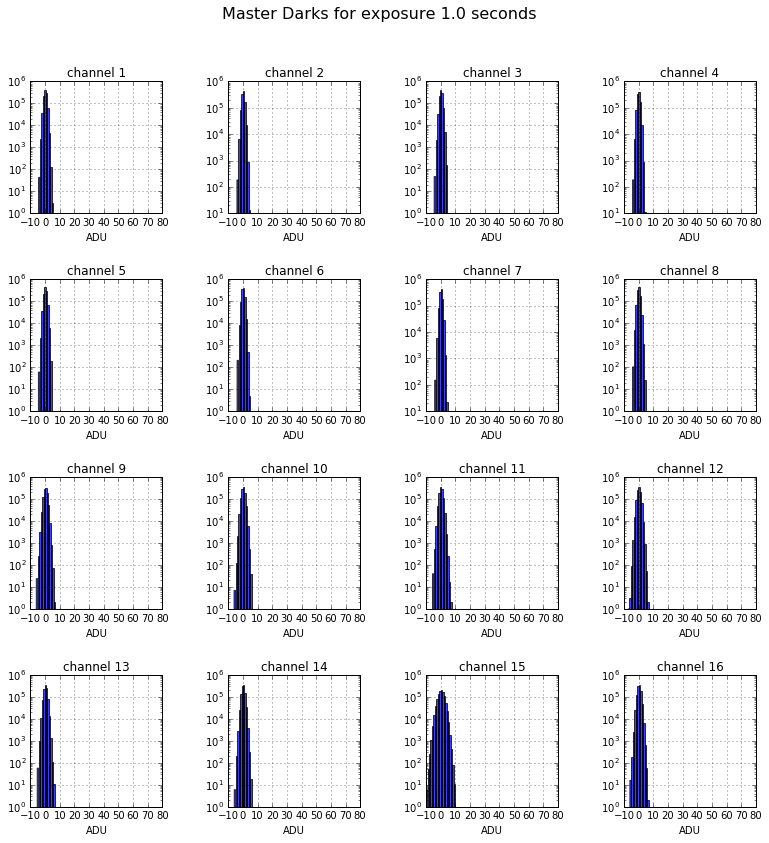

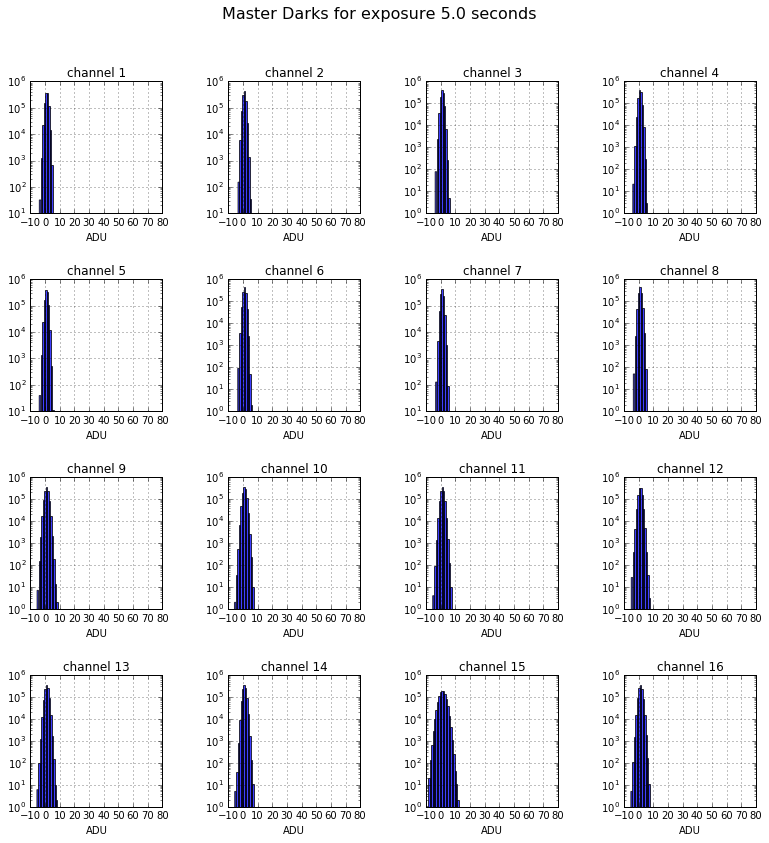

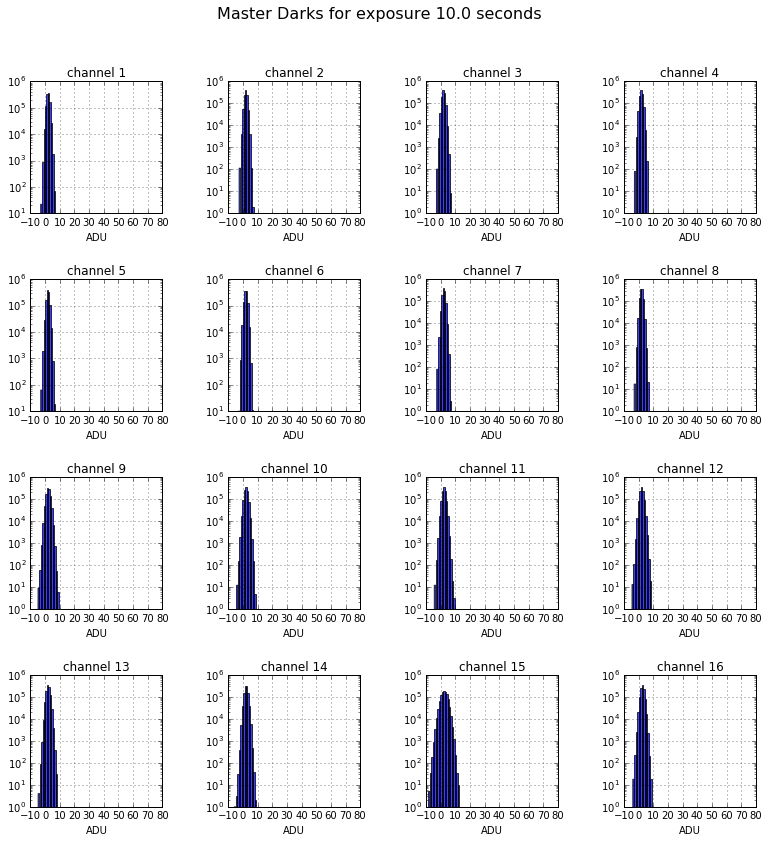

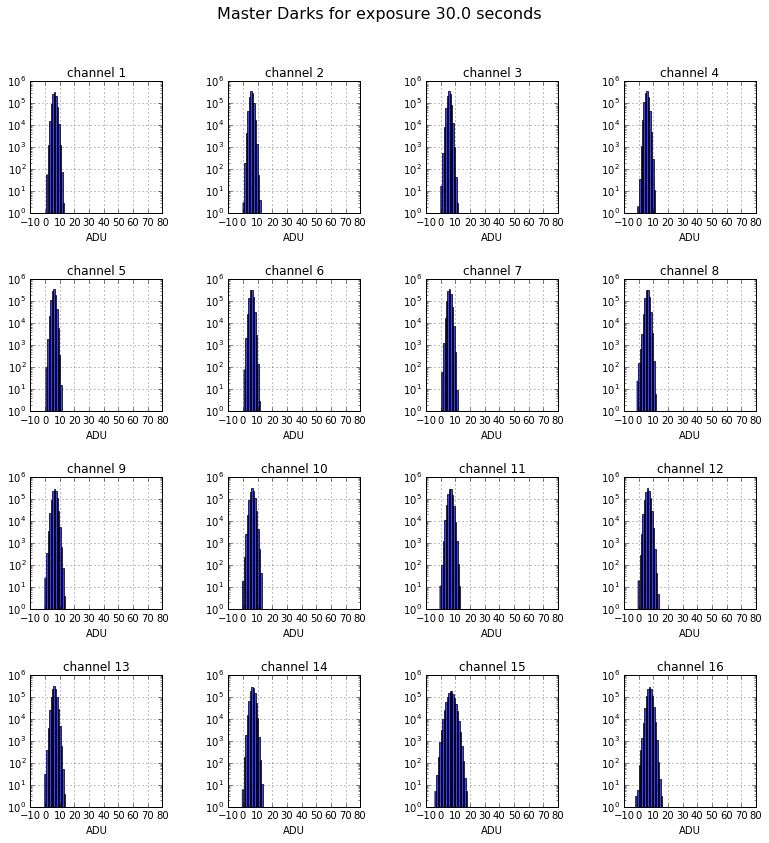

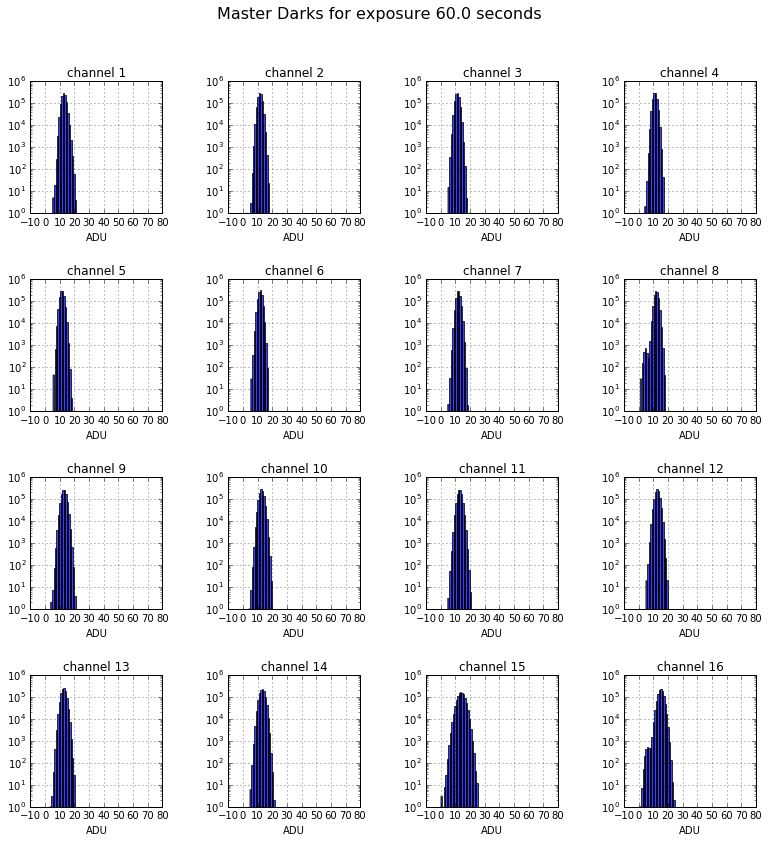

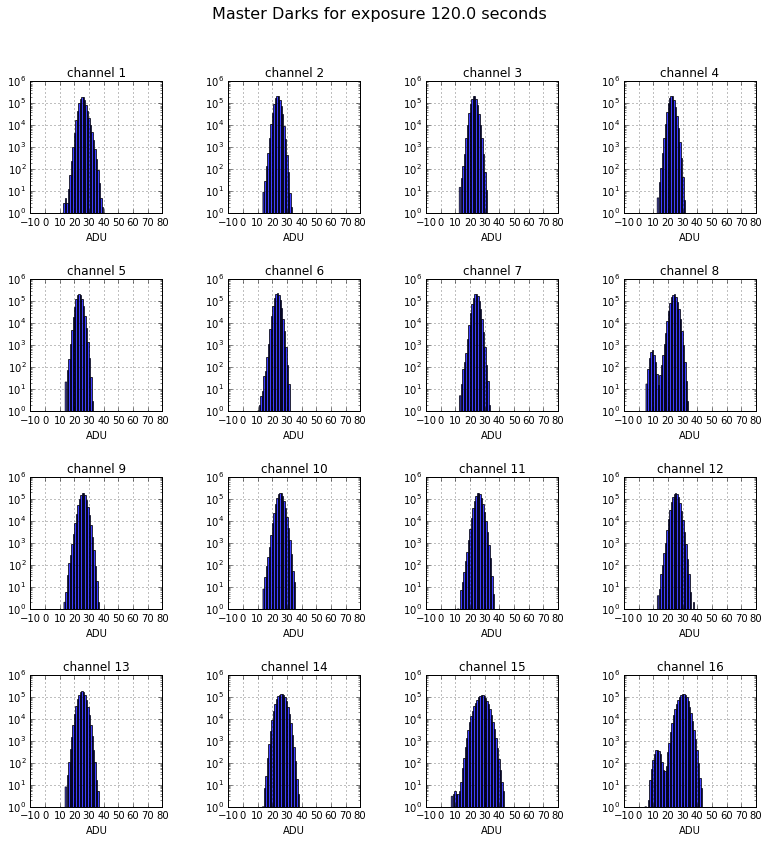

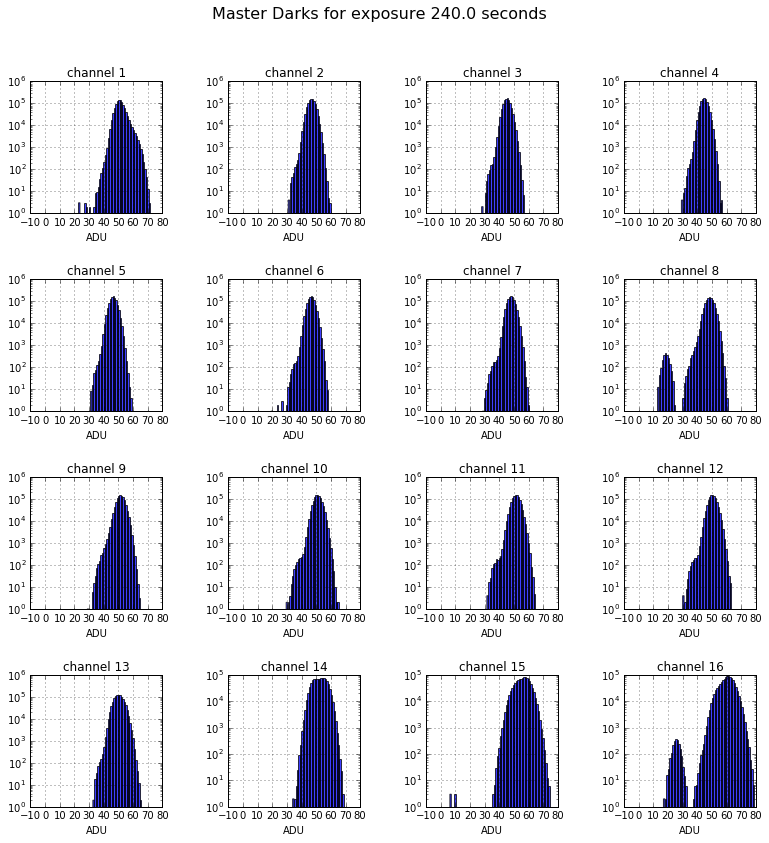

In [43]:
for exposure in exposure_values:
    ShowMasterDarkHistoSet(all_master_darks_subbias,exposure)

In [44]:
def ShowMasterDarkCurve(masterdarks):
    '''

    '''
       
    NX=1 # number of images along the horizontal axis
    NY=1 # number of images along the vertical axis
    f, axarr = plt.subplots(NY,NX,figsize=(10,10)) # figure organisation

    
    
    for index in range(NB_OF_CHAN_AMPL):      
        numchan=index
        label='channel {}'.format(index+1)
        
        darks_mean=np.zeros(len(list_exposures))
        darks_rms=np.zeros(len(list_exposures))
        darks_expo=np.zeros(len(list_exposures))
        
        expo_index=0
        
        for expo in list_exposures:
            image_data = masterdarks[index][expo].data[0:2000,:]
            
            darks_mean[expo_index]=(image_data.flatten()).mean()
            darks_rms[expo_index]=(image_data.flatten()).std()
            darks_expo[expo_index]=expo
            
            expo_index=expo_index+1
            
        plt.plot(list_exposures,darks_mean,'o-',label=label)
    
    plt.ylabel('ADU')
    plt.xlabel('Exposure (s)')
    plt.grid(True)
    plt.legend(loc='best')

    title='Average Dark corrected from bias versus exposure'
    plt.suptitle(title,size=16)
    plt.savefig('masterdark_ostrim_curve.pdf', bbox_inches='tight')
    plt.show()



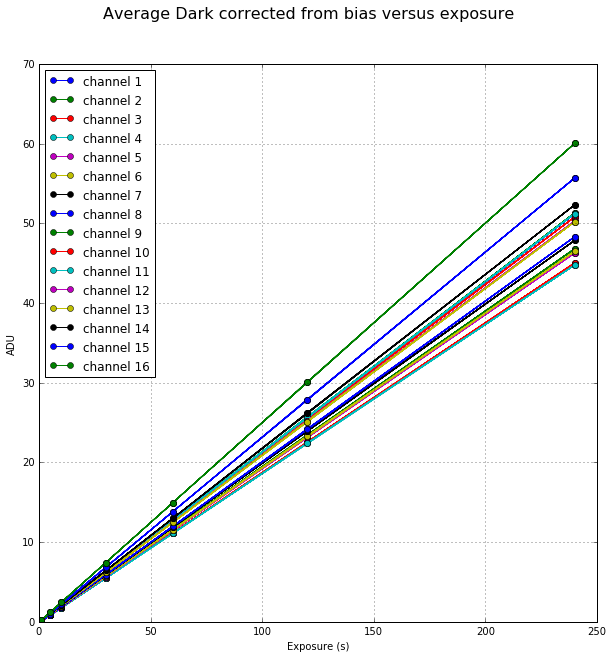

In [45]:
ShowMasterDarkCurve(all_master_darks_subbias)

### 7.3.3) Combine all darks exposures 

- Now combines all darks given the fact they scale with exposure.
- Every darks normalised to 1 second exposure.

In [46]:
all_master_darks_exposcaled=[]
invexpo=1./exposure_values
for chan in range(NB_OF_CHAN_AMPL):
    combined_master_darks_sb = [] 
    for expo in list_exposures:
        timenormaliseddark=all_master_darks_subbias[chan][expo].data/expo        
        combined_master_darks_sb.append(ccdproc.CCDData(timenormaliseddark,unit=u.adu))   
    all_master_darks_exposcaled.append(ccdproc.Combiner(combined_master_darks_sb).average_combine())

- Function to show histograms of darks at 1 second exposure

In [47]:
def ShowMasterSingleDarkHisto(masterdarks):
    '''
    Shows the whole set of CCD histograms
     - inputs argument:
       path : path of the fits file
       filename of the fits file
     - output the images of the whole CCD   
    '''
    
    NX=4 # number of images along the horizontal axis
    NY=4 # number of images along the vertical axis
    DARKMIN=-5.
    DARKMAX=5.
    BINWIDTH=0.25
    f, axarr = plt.subplots(NY,NX,figsize=(13,13)) # figure organisation
    
    f.subplots_adjust(hspace=0.5,wspace=0.5)

    for index in range(NB_OF_CHAN_AMPL):  
        ix=index%4
        iy=index/4
        image_data = image_data = masterdarks[index].data[0:2000,:]
        data=image_data.flatten()
        print 'channel',index+1,'Normalised darks mean =',data.mean(),' darks rms', data.std()
        axarr[iy,ix].hist(data,bins=np.arange(min(data), max(data) + BINWIDTH, BINWIDTH),facecolor='blue', alpha=0.75,log=True)  # plot the image
        #axarr[iy,ix].hist(data,bins=np.arange(min(data), max(data) + BINWIDTH, BINWIDTH),facecolor='blue', alpha=0.70,log=False)  # plot the image
        plottitle='channel {}'.format(index+1)
        axarr[iy,ix].set_xlim(DARKMIN,DARKMAX)
        axarr[iy,ix].set_title(plottitle)
        axarr[iy,ix].set_xlabel('ADU')
        axarr[iy,ix].grid(True)
        #axarr[iy,ix].set_yscale('log')

    plt.yscale('log')
    title='Normalised Master Darks Exposure=1 second'
    plt.suptitle(title,size=16)
    plt.savefig('normmasterdark_ostrim_histos.pdf', bbox_inches='tight')

channel 1 Normalised darks mean = 0.193983560382  darks rms 0.150210192023
channel 2 Normalised darks mean = 0.171662557547  darks rms 0.142925597299
channel 3 Normalised darks mean = 0.162297617022  darks rms 0.14638773556
channel 4 Normalised darks mean = 0.15880161987  darks rms 0.145285629004
channel 5 Normalised darks mean = 0.164832199212  darks rms 0.148497039948
channel 6 Normalised darks mean = 0.173372962706  darks rms 0.145163353202
channel 7 Normalised darks mean = 0.173136886003  darks rms 0.149333828977
channel 8 Normalised darks mean = 0.175667787622  darks rms 0.143155694946
channel 9 Normalised darks mean = 0.194095139449  darks rms 0.187268636644
channel 10 Normalised darks mean = 0.194072756605  darks rms 0.178052974677
channel 11 Normalised darks mean = 0.191335729189  darks rms 0.179377603047
channel 12 Normalised darks mean = 0.188733561631  darks rms 0.179307213068
channel 13 Normalised darks mean = 0.187044769174  darks rms 0.180851361011
channel 14 Normalised d

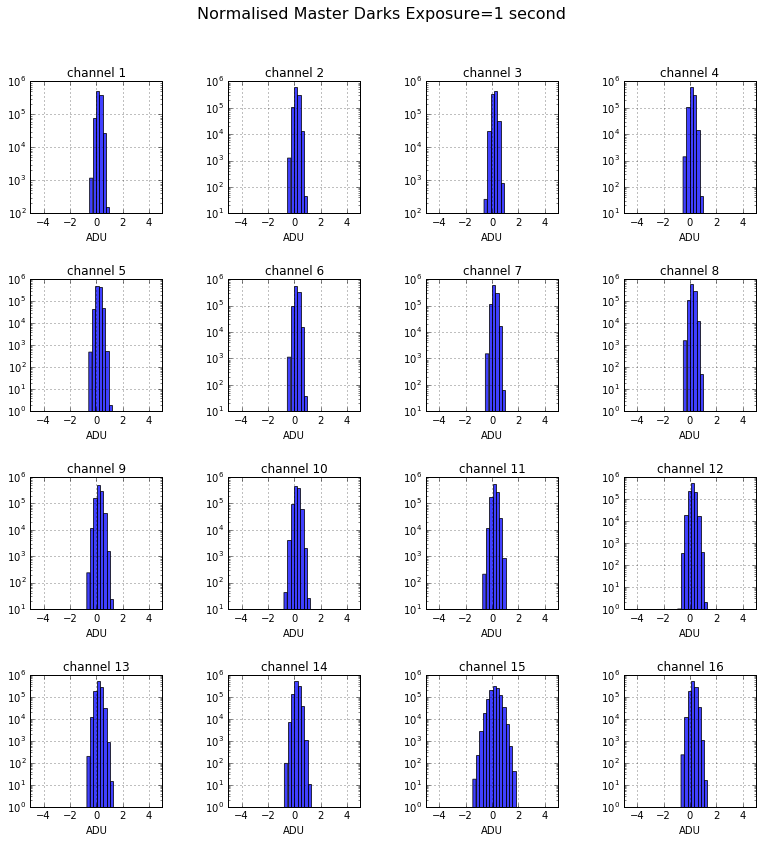

In [48]:
ShowMasterSingleDarkHisto(all_master_darks_exposcaled)

In [49]:
monoc.SaveCCDListIntoFitsFile(all_master_darks_exposcaled,masterdark_out_filename,mbheader,imagetyp='master_dark')

header to be written in file ::
-------------------------------
1
OrderedDict([(u'NCOMBINE', 40)])
2
OrderedDict([(u'NCOMBINE', 40)])
3
OrderedDict([(u'NCOMBINE', 40)])
4
OrderedDict([(u'NCOMBINE', 40)])
5
OrderedDict([(u'NCOMBINE', 40)])
6
OrderedDict([(u'NCOMBINE', 40)])
7
OrderedDict([(u'NCOMBINE', 40)])
8
OrderedDict([(u'NCOMBINE', 40)])
9
OrderedDict([(u'NCOMBINE', 40)])
10
OrderedDict([(u'NCOMBINE', 40)])
11
OrderedDict([(u'NCOMBINE', 40)])
12
OrderedDict([(u'NCOMBINE', 40)])
13
OrderedDict([(u'NCOMBINE', 40)])
14
OrderedDict([(u'NCOMBINE', 40)])
15
OrderedDict([(u'NCOMBINE', 40)])
16
OrderedDict([(u'NCOMBINE', 40)])
Filename: (No file associated with this HDUList)
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       4   ()              
1                ImageHDU         7   (511, 2048)   float64   
2                ImageHDU         7   (511, 2048)   float64   
3                ImageHDU         7   (511, 2048)   float64   
4                I

## 8) Flats
=============

### 8.1) Define the raw flats

In [50]:
root_skyflatfilename='skyflats_'
skyflat_startnum=1
skyflat_stopnum=40 
skyflat_exposure=1.

In [51]:
rawskyflat_list=BuildFilelist(path,root_skyflatfilename,start=skyflat_startnum,stop=skyflat_stopnum)

In [52]:
NB_OF_SKYFLATS=len(rawskyflat_list)

In [53]:
allskyflat = []
for chan in range(1,NB_OF_CHAN_AMPL+1,1):
    ccd_chan = [ ccdproc.CCDData.read(image_file, hdu=chan,unit="adu") for image_file in rawskyflat_list ]
    allskyflat.append(ccd_chan)